**Bias in AI-Based Traffic Ticketing: Analyzing Disproportionate Impacts on Racial Groups and Demographic Disparities**

**OAKLAND**

**Step 1: Load the Dataset and Preprocess the Data**

In [ ]:
import pandas as pd
import zipfile
import os

zip_path = '/content/yg821jf8611_ca_oakland_2020_04_01.csv.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files:", os.listdir(extract_path))

csv_file = os.path.join(extract_path, 'ca_oakland_2020_04_01.csv')

df = pd.read_csv(csv_file)

df.head()

Extracted files: ['.config', 'ca_oakland_2020_04_01.csv', 'yg821jf8611_ca_oakland_2020_04_01.csv.zip', 'sample_data']


<ipython-input-2-06a7cc9e8589>:21: DtypeWarning: Columns (6,10,22,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


,raw_row_number,date,time,location,lat,lng,beat,subject_age,subject_race,subject_sex,...,contraband_weapons,search_conducted,search_basis,reason_for_stop,use_of_force_description,raw_subject_sdrace,raw_subject_resultofencounter,raw_subject_searchconducted,raw_subject_typeofsearch,raw_subject_resultofsearch
0,17213,NaN,01:33:00,E. 28th St. & Park BLVD,37.803084,-122.237247,NaN,NaN,asian/pacific islander,female,...,NaN,False,NaN,Traffic Violation,NaN,A,"Citation,",No,NaN,NaN
1,17214,NaN,14:48:00,1759 SEMINARY AV,37.767568,-122.196820,NaN,NaN,black,male,...,False,True,other,Probation/Parole,NaN,B,"FI Report,",Yes,"Prob./Parole,",NaN
2,1,2013-04-01,00:00:00,31st St And Mlk Jr Way,37.820599,-122.270734,NaN,NaN,white,male,...,False,True,other,Traffic Violation,NaN,W,"Warning,",Yes,"Prob./Parole,",NaN
3,2,2013-04-01,00:01:00,3000 Block Of San Pablo Ave,37.821246,-122.276488,NaN,NaN,black,male,...,NaN,False,NaN,Traffic Violation,NaN,B,"FI Report,",No,NaN,NaN
4,19,2013-04-01,10:41:00,12th St/Broadway,37.802937,-122.271738,NaN,NaN,hispanic,female,...,NaN,False,NaN,Probable Cause,NaN,H,"Citation,",No,NaN,NaN


In [ ]:

print("DataFrame shape:", df.shape)

print("\nFeatures:")
print(df.columns.tolist())

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values (per column):")
print(df.isnull().sum())

DataFrame shape: (133407, 28)

Features:
['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'beat', 'subject_age', 'subject_race', 'subject_sex', 'officer_assignment', 'type', 'arrest_made', 'citation_issued', 'warning_issued', 'outcome', 'contraband_found', 'contraband_drugs', 'contraband_weapons', 'search_conducted', 'search_basis', 'reason_for_stop', 'use_of_force_description', 'raw_subject_sdrace', 'raw_subject_resultofencounter', 'raw_subject_searchconducted', 'raw_subject_typeofsearch', 'raw_subject_resultofsearch']

Data Types:
raw_row_number                    object
date                              object
time                              object
location                          object
lat                              float64
lng                              float64
beat                              object
subject_age                      float64
subject_race                      object
subject_sex                       object
officer_assignment                objec

In [ ]:
import pandas as pd
import numpy as np


df = df.dropna(subset=['date', 'type'])

# boolean columns → fill missing as False
bool_cols = ['arrest_made', 'citation_issued', 'warning_issued', 'search_conducted']
for c in bool_cols:
    df[c] = df[c].fillna(False)



# numeric cols → fill with median
num_cols = ['lat','lng','subject_age']
medians = df[num_cols].median()
df[num_cols] = df[num_cols].fillna(medians)

# categorical cols → fill with "Unknown"
cat_cols = [
    'location','beat','subject_race','subject_sex','officer_assignment',
    'type','outcome','contraband_found','contraband_drugs','contraband_weapons',
    'search_basis','reason_for_stop','use_of_force_description',
    'raw_subject_sdrace','raw_subject_resultofencounter','raw_subject_searchconducted',
    'raw_subject_typeofsearch','raw_subject_resultofsearch'
]
for c in cat_cols:
    df[c] = df[c].fillna("Unknown")


# parse `date` → datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
# parse `time` → hour integer
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.hour
df = df.drop(columns=['time'])

for c in cat_cols:
    df[c] = df[c].str.lower().astype('category')

df['subject_sex'] = df['subject_sex'].apply(
    lambda x: x if x in ['male','female'] else 'unknown'
).astype('category')

# quick check
print("Missing values per column after cleaning:")
print(df.isna().sum())
print("\nData types:")
print(df.dtypes)


<ipython-input-4-28b12728333f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].fillna(False)
<ipython-input-4-28b12728333f>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[num_cols] = df[num_cols].fillna(medians)
<ipython-input-4-28b12728333f>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Missing values per column after cleaning:
raw_row_number                       0
date                                 0
location                             0
lat                                  0
lng                                  0
beat                                 0
subject_age                          0
subject_race                         0
subject_sex                          0
officer_assignment                   0
type                                 0
arrest_made                          0
citation_issued                      0
warning_issued                       0
outcome                              0
contraband_found                 28768
contraband_drugs                 28768
contraband_weapons               28768
search_conducted                     0
search_basis                         0
reason_for_stop                      0
use_of_force_description             0
raw_subject_sdrace                   0
raw_subject_resultofencounter        0
raw_subject_searchcond

In [ ]:
'''# Step 4: Feature Engineering
# Extract year, month, and hour from the date and time columns
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.hour

# Create a binary column for nighttime stops (7 PM - 6 AM)
df['is_night'] = df['hour'].apply(lambda x: 1 if (x >= 19 or x <= 6) else 0)'''

"# Step 4: Feature Engineering\n# Extract year, month, and hour from the date and time columns\ndf['year'] = df['date'].dt.year\ndf['month'] = df['date'].dt.month\ndf['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S', errors='coerce').dt.hour\n\n# Create a binary column for nighttime stops (7 PM - 6 AM)\ndf['is_night'] = df['hour'].apply(lambda x: 1 if (x >= 19 or x <= 6) else 0)"

In [ ]:
from sklearn.preprocessing import LabelEncoder

race_encoder = LabelEncoder()
sex_encoder = LabelEncoder()
type_encoder = LabelEncoder()

df['subject_race_encoded'] = race_encoder.fit_transform(df['subject_race'])
df['subject_sex_encoded'] = sex_encoder.fit_transform(df['subject_sex'])
df['type_encoded'] = type_encoder.fit_transform(df['type'])

print("\n🔍 Label Mappings:")
print("Race:", dict(zip(race_encoder.classes_, race_encoder.transform(race_encoder.classes_))))
print("Sex:", dict(zip(sex_encoder.classes_, sex_encoder.transform(sex_encoder.classes_))))
print("Type:", dict(zip(type_encoder.classes_, type_encoder.transform(type_encoder.classes_))))

print("\n🧾 Encoded Data Preview:")
print(df[['subject_race', 'subject_race_encoded', 'subject_sex', 'subject_sex_encoded', 'type', 'type_encoded']].head())



🔍 Label Mappings:
Race: {'asian/pacific islander': np.int64(0), 'black': np.int64(1), 'hispanic': np.int64(2), 'other': np.int64(3), 'white': np.int64(4)}
Sex: {'female': np.int64(0), 'male': np.int64(1), 'unknown': np.int64(2)}
Type: {'pedestrian': np.int64(0), 'vehicular': np.int64(1)}

🧾 Encoded Data Preview:
  subject_race  subject_race_encoded subject_sex  subject_sex_encoded  \
2        white                     4        male                    1   
3        black                     1        male                    1   
5        white                     4        male                    1   
6        black                     1        male                    1   
7        black                     1        male                    1   

        type  type_encoded  
2  vehicular             1  
3  vehicular             1  
5  vehicular             1  
6  vehicular             1  
7  vehicular             1  


In [ ]:

df.to_csv("processed_data.csv", index=False)
print("Data Preprocessing Completed & Saved!")

Data Preprocessing Completed & Saved!


**Step 2: Exploratory Data Analysis**

In [ ]:
# Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

df = pd.read_csv("processed_data.csv")

**Traffic Stops by Race & Gender- This plot helps visualize racial and gender disparities in traffic stops**

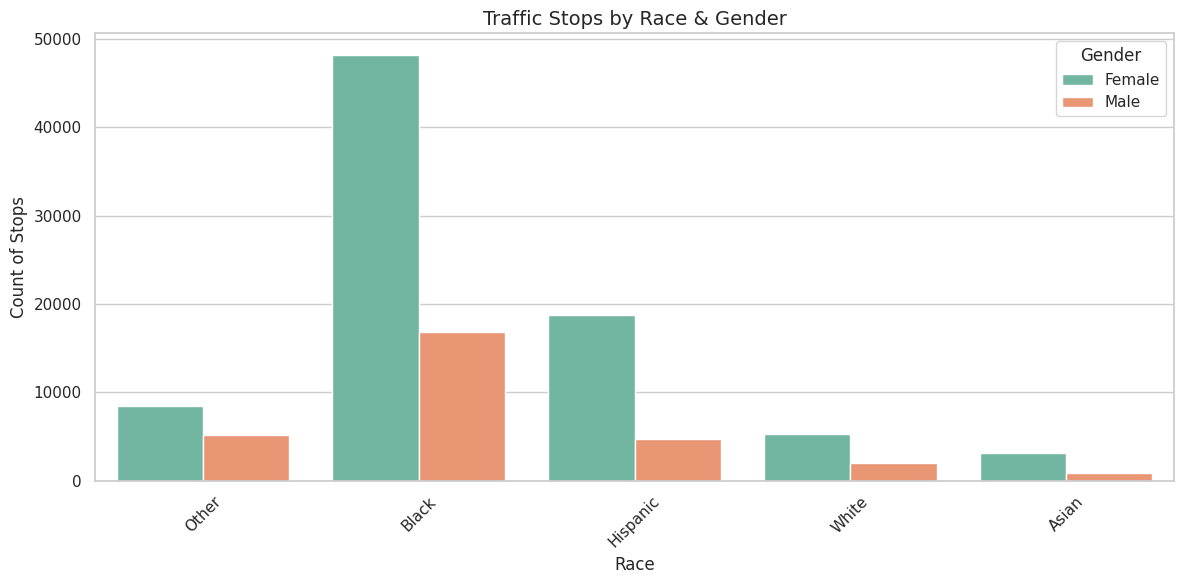

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

race_mapping   = {0: "White", 1: "Black", 2: "Hispanic", 3: "Asian", 4: "Other"}
gender_mapping = {0: "Male",  1: "Female"}

df["subject_race_label"] = df["subject_race_encoded"].replace(race_mapping)
df["subject_sex_label"]  = df["subject_sex_encoded"].replace(gender_mapping)

plot_df = df[df["subject_sex_label"].isin(["Male","Female"])].copy()

plt.figure(figsize=(12, 6))
sns.countplot(
    data=plot_df,
    x="subject_race_label",
    hue="subject_sex_label",
    palette="Set2"
)
plt.title("Traffic Stops by Race & Gender", fontsize=14)
plt.xlabel("Race")
plt.ylabel("Count of Stops")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.tight_layout()
plt.show()


**Traffic Stop Rate by District & Region**

<Figure size 1800x1200 with 0 Axes>

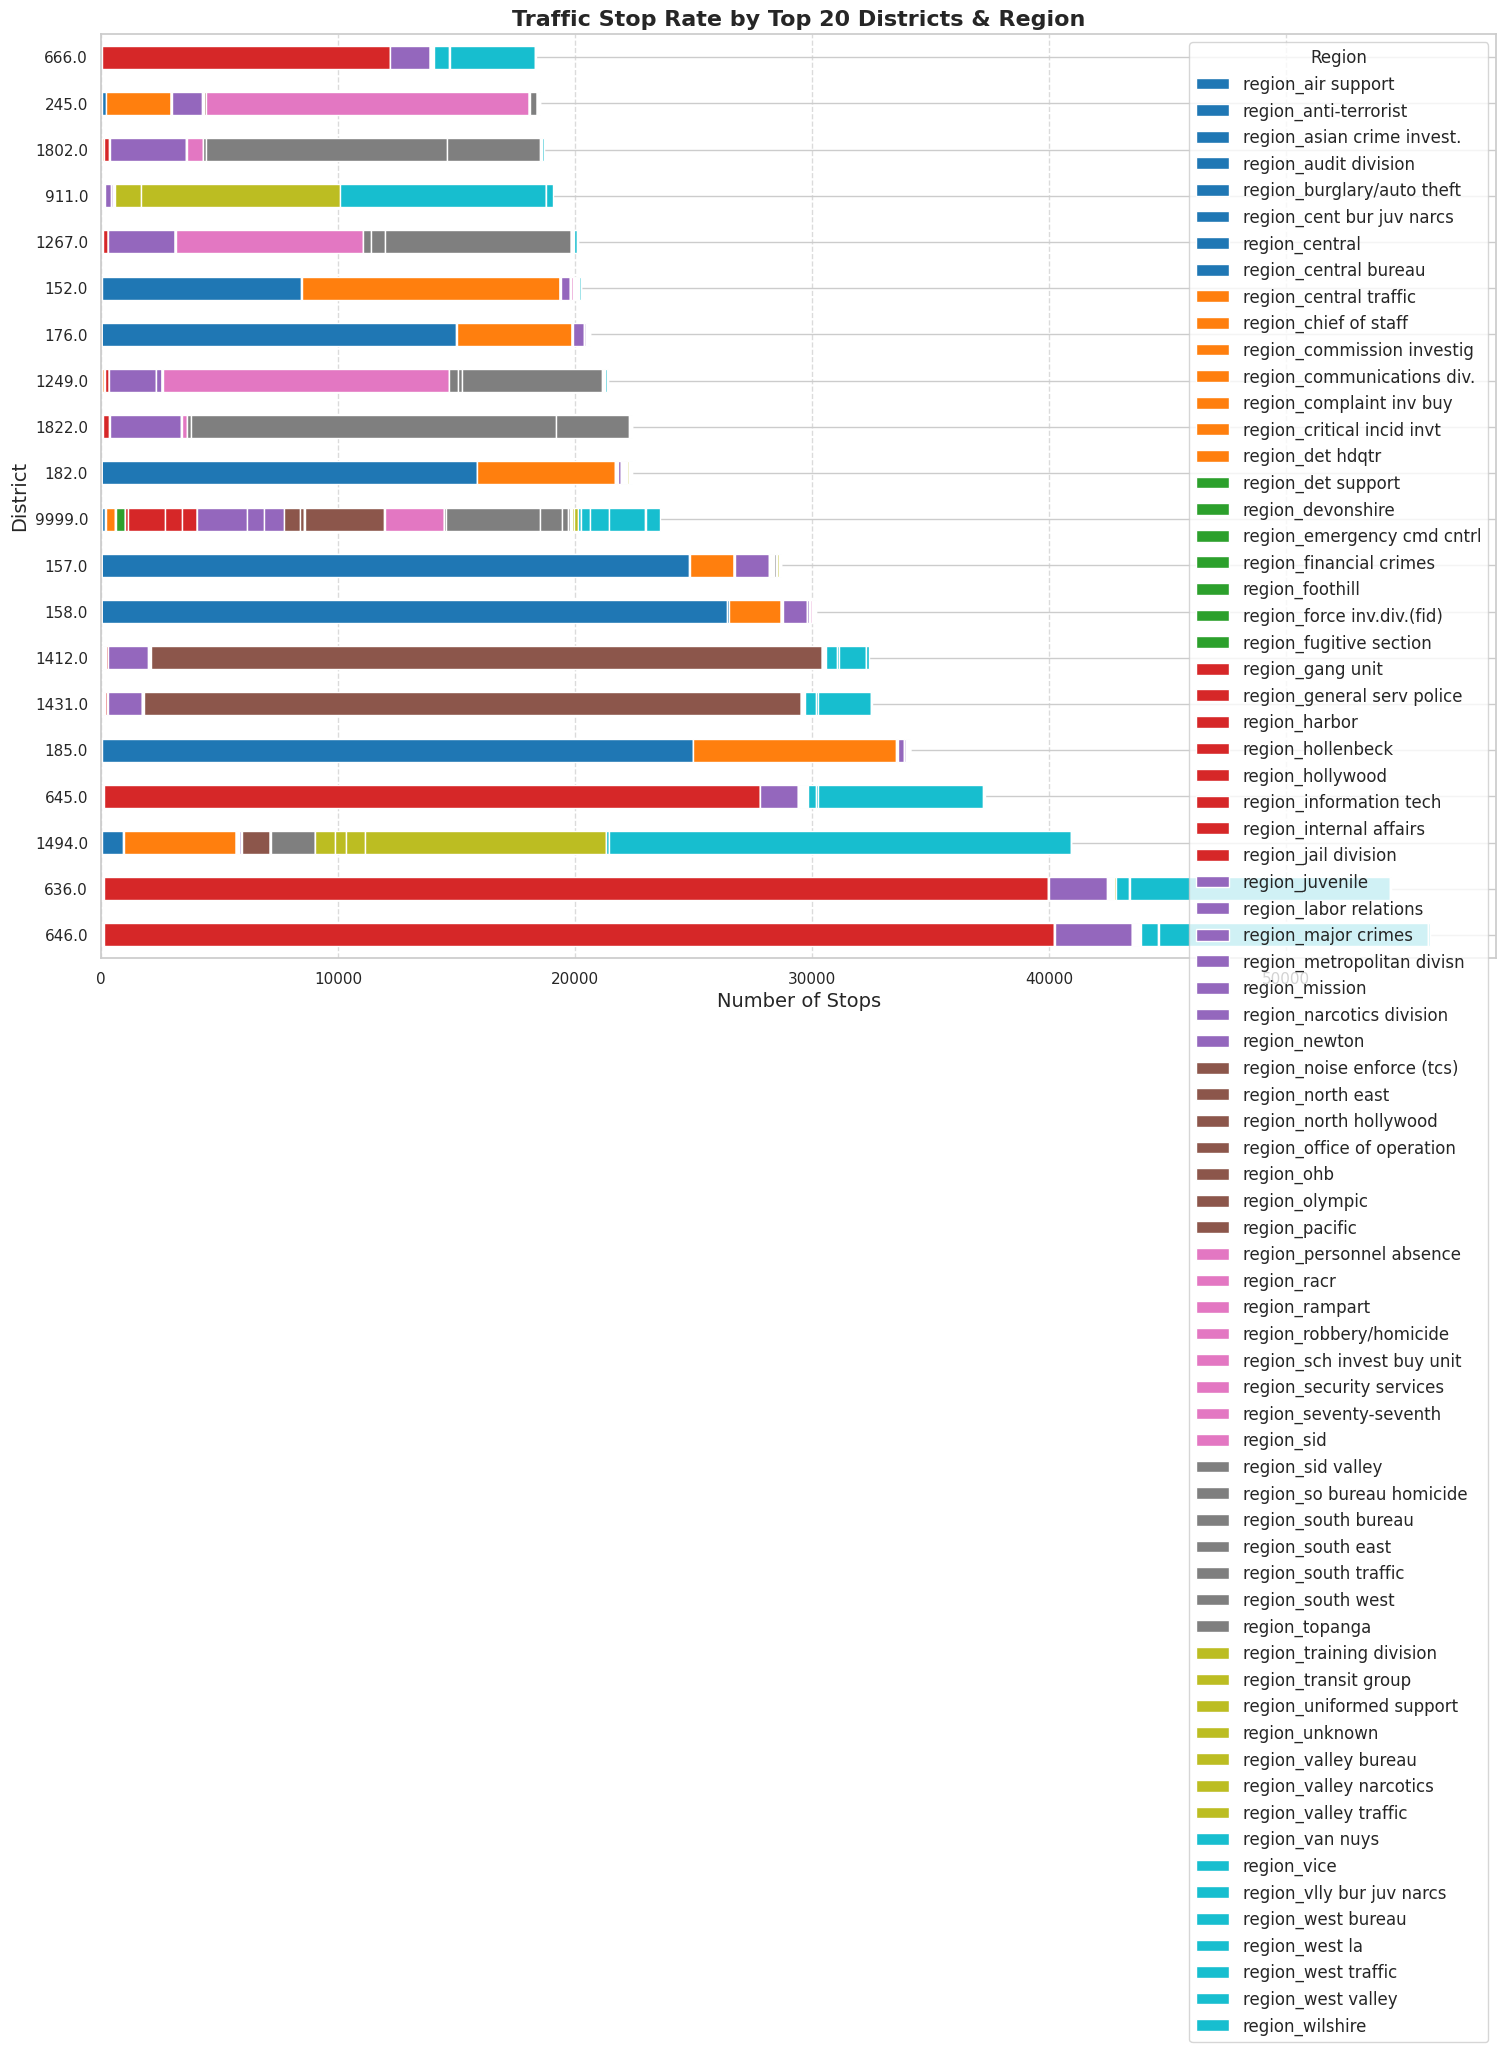

In [ ]:
'''import matplotlib.pyplot as plt

# ✅ Select region columns dynamically
region_columns = [col for col in df.columns if col.startswith('region_')]

# ✅ Create a new column for the region by combining the existing ones
df['region'] = df[region_columns].idxmax(axis=1)  # Get the name of the column with the highest value for each row

# ✅ Group by district and the newly created region column
district_region_counts = df.groupby(['district', 'region']).size().unstack(fill_value=0)

# ✅ Sort districts by total stops and keep only top 20
top_districts = district_region_counts.sum(axis=1).sort_values(ascending=False).head(20)
district_region_counts = district_region_counts.loc[top_districts.index]

# ✅ Plot the graph
plt.figure(figsize=(18, 12))
district_region_counts.plot(kind="barh", stacked=True, colormap="tab10", figsize=(18, 12))

# ✅ Customize the plot
plt.title("Traffic Stop Rate by Top 20 Districts & Region", fontsize=16, fontweight='bold')
plt.xlabel("Number of Stops", fontsize=14)
plt.ylabel("District", fontsize=14)
plt.legend(title="Region", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)

# ✅ Show the plot
plt.show()'''

**Violation Type Analysis (Pedestrian vs. Vehicular)**

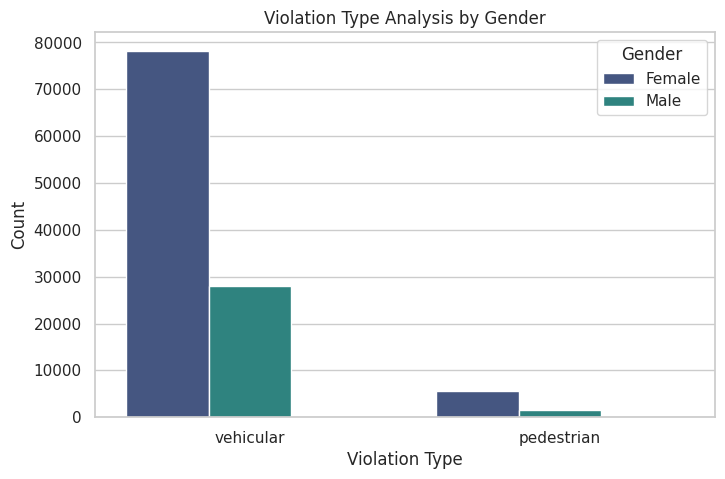

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="type", hue="subject_sex", palette="viridis")

plt.title("Violation Type Analysis by Gender")
plt.xlabel("Violation Type")
plt.ylabel("Count")
plt.legend(title="Gender", labels=["Female", "Male"])  # Explicitly setting labels

plt.show()

**Temporal Analysis (Bias Patterns Based on Time & Year)- If certain years saw spikes in stops, it might correlate with policy changes or events**

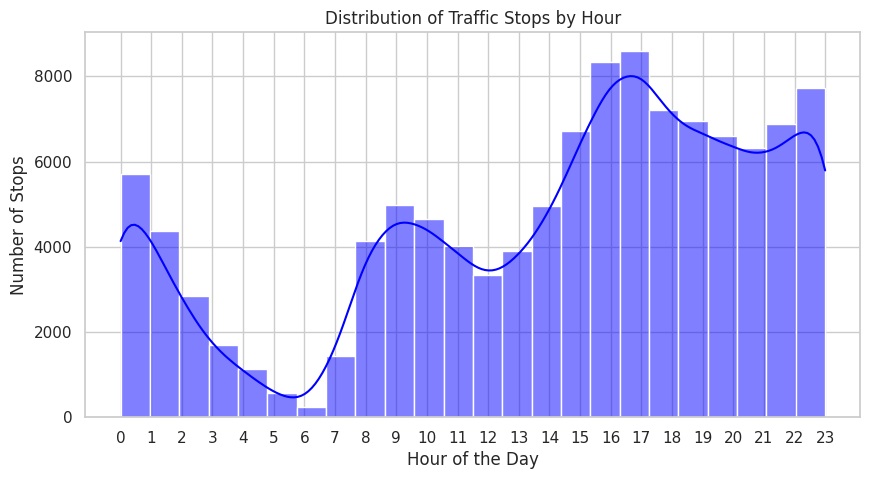

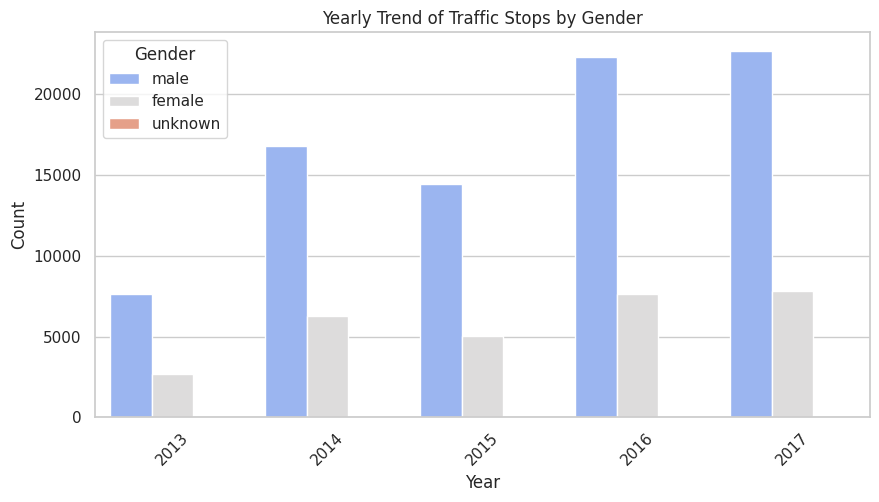

In [ ]:
# Stops by Hour of the Day
plt.figure(figsize=(10, 5))
sns.histplot(df['hour'], bins=24, kde=True, color="blue")
plt.title("Distribution of Traffic Stops by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Stops")
plt.xticks(range(0, 24))
plt.show()

# Stops Over the Years

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="year", hue="subject_sex", palette="coolwarm")
plt.title("Yearly Trend of Traffic Stops by Gender")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Gender")
plt.show()


**Are Minority Groups Stopped More at Night?**

In [ ]:
print(df.columns.tolist())


['raw_row_number', 'date', 'location', 'lat', 'lng', 'beat', 'subject_age', 'subject_race', 'subject_sex', 'officer_assignment', 'type', 'arrest_made', 'citation_issued', 'warning_issued', 'outcome', 'contraband_found', 'contraband_drugs', 'contraband_weapons', 'search_conducted', 'search_basis', 'reason_for_stop', 'use_of_force_description', 'raw_subject_sdrace', 'raw_subject_resultofencounter', 'raw_subject_searchconducted', 'raw_subject_typeofsearch', 'raw_subject_resultofsearch', 'hour', 'year', 'month', 'subject_race_encoded', 'subject_sex_encoded', 'type_encoded', 'subject_race_label', 'subject_sex_label']


No 'is night' attribute

**Step 3: Bias Detection with Fairness Metrics**

**Bias Mitigation Technique- Using Adversarial Debiasing and Reweighting as these will give both direct debiasing during training and data balancing techniques. Fairness Metrics- using Demographic Parity, and Disparate Impact. These metrics cover different aspects of fairness: Demographic Parity for overall group fairness, Disparate Impact for identifying any unintended adverse impacts.**

In [ ]:
# Get unique values for race and sex
distinct_races = df['subject_race'].unique()
distinct_sexes = df['subject_sex'].unique()
distinct_offences= df['type'].unique()

print("Distinct subject races:", distinct_races)
print("Distinct subject sexes:", distinct_sexes)
print("Distinct subject offences:", distinct_offences)

Distinct subject races: ['white' 'black' 'hispanic' 'asian/pacific islander' 'other']
Distinct subject sexes: ['male' 'female' 'unknown']
Distinct subject offences: ['vehicular' 'pedestrian']


In [ ]:
df.head()

,raw_row_number,date,location,lat,lng,beat,subject_age,subject_race,subject_sex,officer_assignment,...,raw_subject_typeofsearch,raw_subject_resultofsearch,hour,year,month,subject_race_encoded,subject_sex_encoded,type_encoded,subject_race_label,subject_sex_label
0,1,2013-04-01,31st st and mlk jr way,37.820599,-122.270734,unknown,29.0,white,male,unknown,...,"prob./parole,",unknown,0.0,2013,4,4,1,1,Other,Female
1,2,2013-04-01,3000 block of san pablo ave,37.821246,-122.276488,unknown,29.0,black,male,unknown,...,unknown,unknown,0.0,2013,4,1,1,1,Black,Female
2,20,2013-04-01,2100 west st,37.812199,-122.276388,unknown,29.0,white,male,unknown,...,unknown,unknown,14.0,2013,4,4,1,1,Other,Female
3,4,2013-04-01,2200 blk of magnolia st,37.815760,-122.285080,unknown,29.0,black,male,unknown,...,"inventory,",unknown,0.0,2013,4,1,1,1,Black,Female
4,21,2013-04-01,300 blk hegenberger rd,37.734510,-122.197170,unknown,29.0,black,male,unknown,...,unknown,unknown,15.0,2013,4,1,1,1,Black,Female


In [ ]:
print("Unique values in 'type':", df['type'].unique())
print("Value counts for 'type':\n", df['type'].value_counts())


Unique values in 'type': ['vehicular' 'pedestrian']
Value counts for 'type':
 type
vehicular     106256
pedestrian      7084
Name: count, dtype: int64



=== Vehicular Tickets (Outcome = citation_issued) ===
Overall P(positive): 0.4660254479747026

P(positive) by race:
 subject_race_label
Asian       0.571319
Black       0.402603
Hispanic    0.547989
Other       0.540252
White       0.556455
Name: positive_outcome, dtype: float64

Parity ratio by race:
 subject_race_label
Asian       1.225939
Black       0.863907
Hispanic    1.175877
Other       1.159276
White       1.194044
Name: positive_outcome, dtype: float64

P(positive) by sex:
 subject_sex_label
2         0.052632
Female    0.454227
Male      0.500233
Name: positive_outcome, dtype: float64

Parity ratio by sex:
 subject_sex_label
2         0.112937
Female    0.974683
Male      1.073402
Name: positive_outcome, dtype: float64


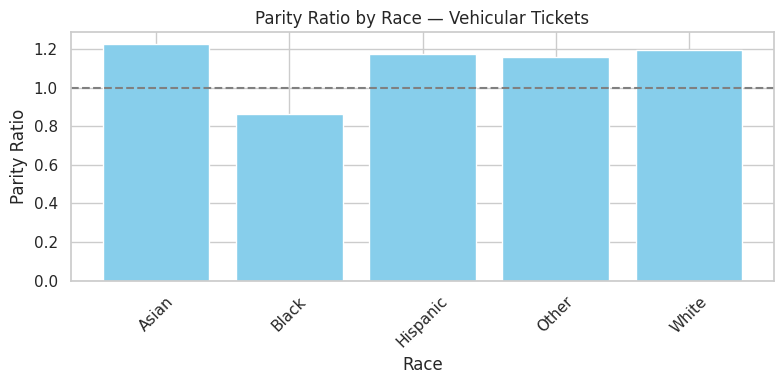

TypeError: the dtypes of parameters x (object) and width (float64) are incompatible

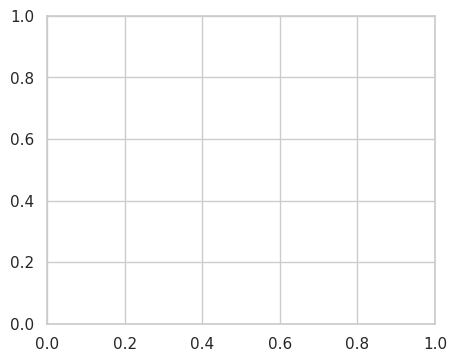

In [ ]:
import matplotlib.pyplot as plt

def plot_parity(df, ticket_type, outcome_col='citation_issued',
                race_col='subject_race_label', sex_col='subject_sex_label'):
    """
    Computing & plotting demographic parity ratios for a given ticket_type
    and binary outcome (default: citation_issued).
    """
    df_sub = df[df['type'] == ticket_type].copy()
    title_suffix = ticket_type.capitalize()

    df_sub['positive_outcome'] = df_sub[outcome_col].astype(int)

    p_overall = df_sub['positive_outcome'].mean()
    p_race    = df_sub.groupby(race_col)['positive_outcome'].mean()
    p_sex     = df_sub.groupby(sex_col )['positive_outcome'].mean()

    parity_race = p_race / p_overall
    parity_sex  = p_sex  / p_overall

    print(f"\n=== {title_suffix} Tickets (Outcome = {outcome_col}) ===")
    print("Overall P(positive):", p_overall)
    print("\nP(positive) by race:\n", p_race)
    print("\nParity ratio by race:\n", parity_race)
    print("\nP(positive) by sex:\n", p_sex)
    print("\nParity ratio by sex:\n", parity_sex)

    plt.figure(figsize=(8,4))
    plt.bar(parity_race.index, parity_race, color='skyblue')
    plt.axhline(1, color='gray', linestyle='--')
    plt.title(f"Parity Ratio by Race — {title_suffix} Tickets")
    plt.ylabel("Parity Ratio")
    plt.xlabel("Race")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5,4))
    plt.bar(parity_sex.index, parity_sex, color='lightgreen')
    plt.axhline(1, color='gray', linestyle='--')
    plt.title(f"Parity Ratio by Sex — {title_suffix} Tickets")
    plt.ylabel("Parity Ratio")
    plt.xlabel("Sex")
    plt.tight_layout()
    plt.show()

race_col = 'subject_race_label' if 'subject_race_label' in df.columns else 'subject_race'
sex_col  = 'subject_sex_label'  if 'subject_sex_label'  in df.columns else 'subject_sex'

for t in ['vehicular', 'pedestrian']:
    plot_parity(df, ticket_type=t,
                outcome_col='citation_issued',
                race_col=race_col, sex_col=sex_col)


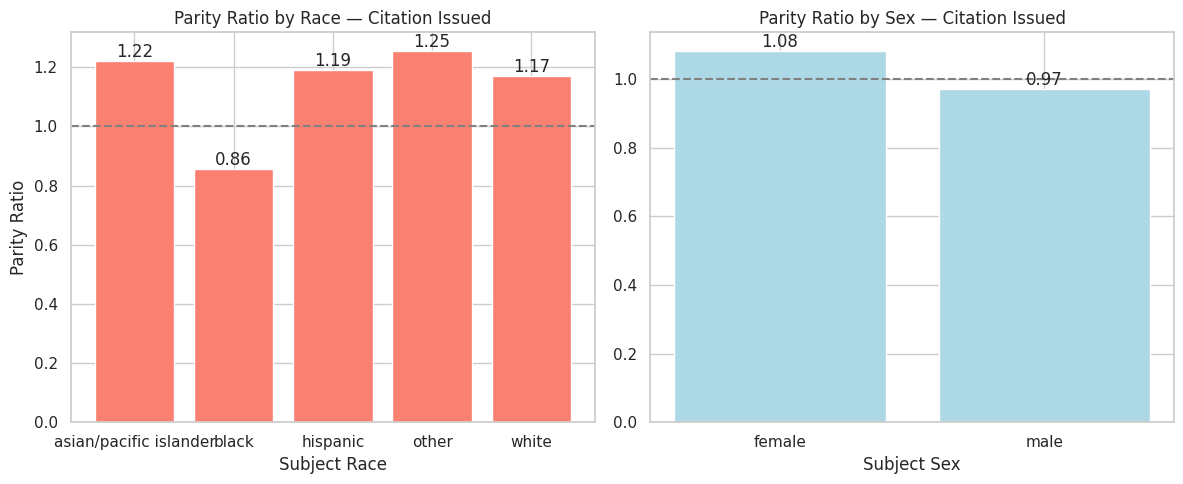

In [ ]:
import matplotlib.pyplot as plt

df['positive_outcome'] = df['citation_issued'].astype(int)

p_pos = df['positive_outcome'].mean()

race_rate = df.groupby('subject_race')['positive_outcome'].mean()

sex_df = df[df['subject_sex'].isin(['male', 'female'])]
sex_rate = sex_df.groupby('subject_sex')['positive_outcome'].mean()

race_parity = race_rate / p_pos
sex_parity  = sex_rate  / p_pos

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(race_parity.index, race_parity, color='salmon')
axes[0].axhline(1, color='gray', linestyle='--')
axes[0].set_title("Parity Ratio by Race — Citation Issued")
axes[0].set_xlabel("Subject Race")
axes[0].set_ylabel("Parity Ratio")
for bar in axes[0].patches:
    axes[0].annotate(f"{bar.get_height():.2f}",
                     (bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha='center', va='bottom')

axes[1].bar(sex_parity.index, sex_parity, color='lightblue')
axes[1].axhline(1, color='gray', linestyle='--')
axes[1].set_title("Parity Ratio by Sex — Citation Issued")
axes[1].set_xlabel("Subject Sex")
for bar in axes[1].patches:
    axes[1].annotate(f"{bar.get_height():.2f}",
                     (bar.get_x() + bar.get_width()/2, bar.get_height()),
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()


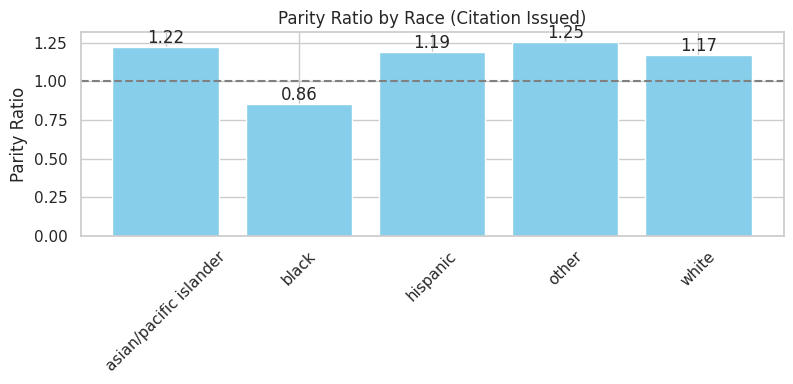

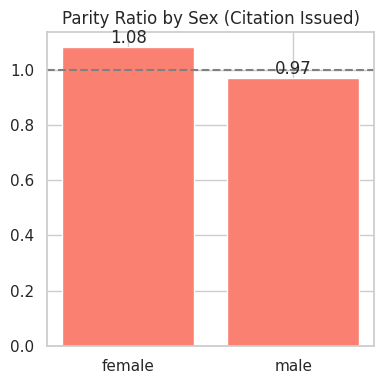

In [ ]:
import matplotlib.pyplot as plt


df['positive_outcome'] = df['citation_issued'].astype(int)

p_y = df['positive_outcome'].mean()

race_rate = df.groupby('subject_race')['positive_outcome'].mean()

sex_rate = (
    df[df['subject_sex'].isin(['male', 'female'])]
    .groupby('subject_sex')['positive_outcome']
    .mean()
)

race_parity = race_rate / p_y
sex_parity  = sex_rate  / p_y

plt.figure(figsize=(8, 4))
bars = plt.bar(race_parity.index, race_parity, color='skyblue')
plt.axhline(1, linestyle='--', color='gray')
plt.title("Parity Ratio by Race (Citation Issued)")
plt.ylabel("Parity Ratio")
plt.xticks(rotation=45)
for b in bars:
    plt.text(
        b.get_x() + b.get_width()/2,
        b.get_height(),
        f"{b.get_height():.2f}",
        ha='center', va='bottom'
    )
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 4))
bars = plt.bar(sex_parity.index, sex_parity, color='salmon')
plt.axhline(1, linestyle='--', color='gray')
plt.title("Parity Ratio by Sex (Citation Issued)")
for b in bars:
    plt.text(
        b.get_x() + b.get_width()/2,
        b.get_height(),
        f"{b.get_height():.2f}",
        ha='center', va='bottom'
    )
plt.tight_layout()
plt.show()


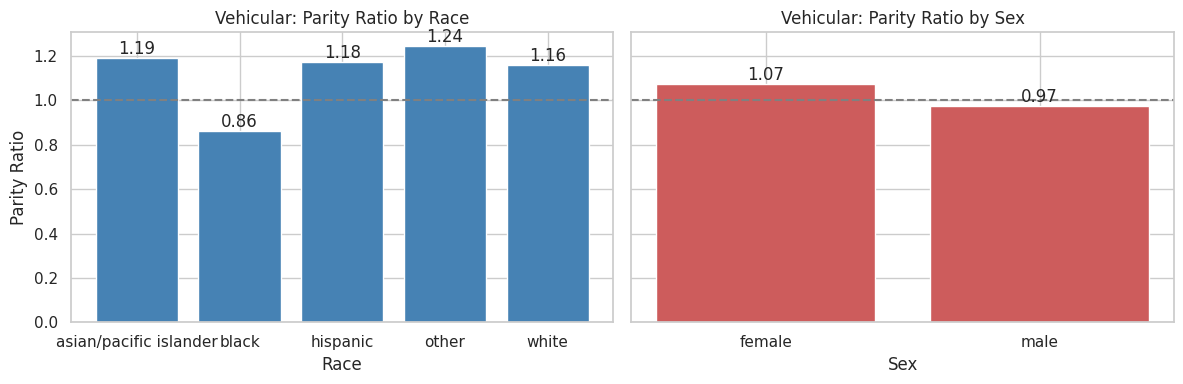

In [ ]:
import matplotlib.pyplot as plt

# ── Vehicular Citation Parity ────────────────────────────────────────────────
veh_df = df[df['type'] == 'vehicular'].copy()

veh_df = veh_df[veh_df['subject_sex'].isin(['male', 'female'])]

veh_df['positive_outcome'] = veh_df['citation_issued'].astype(int)

p_y = veh_df['positive_outcome'].mean()

race_rate = veh_df.groupby('subject_race')['positive_outcome'].mean()
sex_rate  = veh_df.groupby('subject_sex' )['positive_outcome'].mean()

race_parity = race_rate / p_y
sex_parity  = sex_rate  / p_y

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].bar(race_parity.index, race_parity, color='steelblue')
axes[0].axhline(1, color='gray', linestyle='--')
axes[0].set(title="Vehicular: Parity Ratio by Race",
            xlabel="Race", ylabel="Parity Ratio")
for b in axes[0].patches:
    axes[0].annotate(f"{b.get_height():.2f}",
                     (b.get_x()+b.get_width()/2, b.get_height()),
                     ha='center', va='bottom')

axes[1].bar(sex_parity.index, sex_parity, color='indianred')
axes[1].axhline(1, color='gray', linestyle='--')
axes[1].set(title="Vehicular: Parity Ratio by Sex",
            xlabel="Sex")
for b in axes[1].patches:
    axes[1].annotate(f"{b.get_height():.2f}",
                     (b.get_x()+b.get_width()/2, b.get_height()),
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()


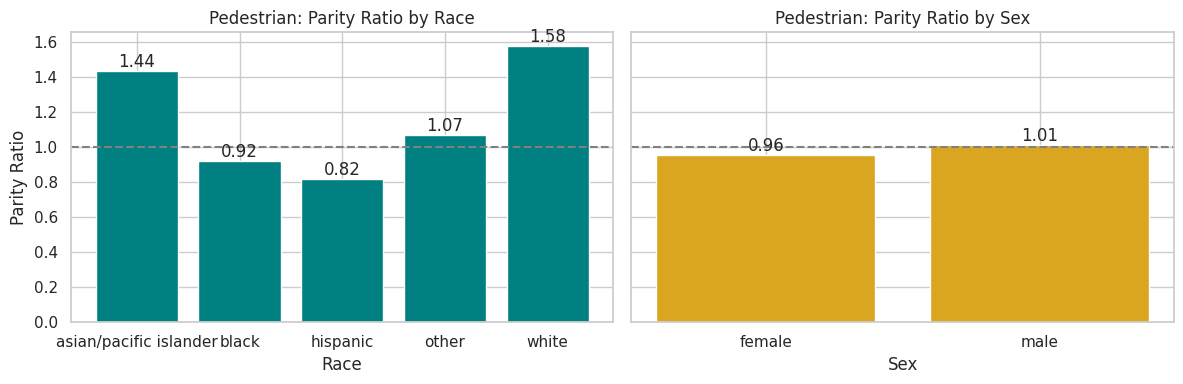

In [ ]:
import matplotlib.pyplot as plt

# ── Pedestrian Citation Parity ───────────────────────────────────────────────
ped_df = df[df['type'] == 'pedestrian'].copy()

ped_df = ped_df[ped_df['subject_sex'].isin(['male', 'female'])]

ped_df['positive_outcome'] = ped_df['citation_issued'].astype(int)

p_y = ped_df['positive_outcome'].mean()

race_rate = ped_df.groupby('subject_race')['positive_outcome'].mean()
sex_rate  = ped_df.groupby('subject_sex' )['positive_outcome'].mean()

race_parity = race_rate / p_y
sex_parity  = sex_rate  / p_y

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].bar(race_parity.index, race_parity, color='teal')
axes[0].axhline(1, color='gray', linestyle='--')
axes[0].set(title="Pedestrian: Parity Ratio by Race",
            xlabel="Race", ylabel="Parity Ratio")
for b in axes[0].patches:
    axes[0].annotate(f"{b.get_height():.2f}",
                     (b.get_x()+b.get_width()/2, b.get_height()),
                     ha='center', va='bottom')

axes[1].bar(sex_parity.index, sex_parity, color='goldenrod')
axes[1].axhline(1, color='gray', linestyle='--')
axes[1].set(title="Pedestrian: Parity Ratio by Sex",
            xlabel="Sex")
for b in axes[1].patches:
    axes[1].annotate(f"{b.get_height():.2f}",
                     (b.get_x()+b.get_width()/2, b.get_height()),
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
# 1) Defining your positive outcome as “got a citation”
df['positive_outcome'] = df['citation_issued'].astype(int)

# 2) Recompute P(Y=y)
n   = len(df)
p_y = df['positive_outcome'].value_counts(normalize=True)

# 3) P(G=g) by race
p_g = df['subject_race'].value_counts(normalize=True)

# 4) Joint P(G=g, Y=y)
joint = df.groupby(['subject_race','positive_outcome']).size().divide(n)

# 5) Compute weights
weights = {
    (g,y): (p_g[g] * p_y[y]) / joint.loc[(g,y)]
    for g,y in joint.index
}

# 6) Turn into a DataFrame
weights_df = (
    pd.Series(weights)
      .rename("weight")
      .reset_index()
      .rename(columns={"level_0":"subject_race","level_1":"positive_outcome"})
)
print(weights_df)

# 7) Apply to each row
df['sample_weight'] = df.apply(
    lambda r: weights.get((r['subject_race'], r['positive_outcome'])), axis=1
)

# 8) Sample check
print(df[['subject_race','positive_outcome','sample_weight']].head())


             subject_race  positive_outcome    weight
0  asian/pacific islander                 0  1.210773
1  asian/pacific islander                 1  0.819795
2                   black                 0  0.897623
3                   black                 1  1.168249
4                hispanic                 0  1.176394
5                hispanic                 1  0.840803
6                   other                 0  1.252986
7                   other                 1  0.796842
8                   white                 0  1.156336
9                   white                 1  0.854175
  subject_race  positive_outcome  sample_weight
0        white                 0       1.156336
1        black                 0       0.897623
2        white                 0       1.156336
3        black                 1       1.168249
4        black                 0       0.897623


In [ ]:
# -------------- Vehicular re-weighting --------------

veh = df[df['type'] == 'vehicular'].copy()

# 1) define positive outcome
veh['positive_outcome'] = veh['citation_issued'].astype(int)

# 2) total
n = len(veh)

# 3) marginals
p_y = veh['positive_outcome'].value_counts(normalize=True)
p_g = veh['subject_race'].value_counts(normalize=True)

# 4) joint
p_g_y = veh.groupby(['subject_race','positive_outcome']).size() / n

# 5) compute weights
weights_veh = {}
for g in p_g.index:
    for y in [0,1]:
        if (g,y) in p_g_y and p_g_y[(g,y)] > 0:
            weights_veh[(g,y)] = (p_g[g] * p_y[y]) / p_g_y[(g,y)]
        else:
            weights_veh[(g,y)] = 0.0

# 6) attach to each row
veh['sample_weight'] = veh.apply(
    lambda r: weights_veh[(r['subject_race'], r['positive_outcome'])],
    axis=1
)

# inspect
print("Vehicular weights:")
print(pd.Series(weights_veh).unstack())
print("\nSample:")
print(veh[['subject_race','positive_outcome','sample_weight']].head())


Vehicular weights:
                               0         1
asian/pacific islander  1.203879  0.837490
black                   0.893835  1.157532
hispanic                1.181330  0.850429
other                   1.245621  0.815701
white                   1.161451  0.862607

Sample:
  subject_race  positive_outcome  sample_weight
0        white                 0       1.161451
1        black                 0       0.893835
2        white                 0       1.161451
3        black                 1       1.157532
4        black                 0       0.893835


In [ ]:
# -------------- Pedestrian re-weighting --------------

ped = df[df['type'] == 'pedestrian'].copy()

# 1) define positive outcome
ped['positive_outcome'] = ped['citation_issued'].astype(int)

# 2) total
n = len(ped)

# 3) marginals
p_y = ped['positive_outcome'].value_counts(normalize=True)
p_g = ped['subject_race'].value_counts(normalize=True)

# 4) joint
p_g_y = ped.groupby(['subject_race','positive_outcome']).size() / n

# 5) compute weights
weights_ped = {}
for g in p_g.index:
    for y in [0,1]:
        if (g,y) in p_g_y and p_g_y[(g,y)] > 0:
            weights_ped[(g,y)] = (p_g[g] * p_y[y]) / p_g_y[(g,y)]
        else:
            weights_ped[(g,y)] = 0.0

# 6) attach to each row
ped['sample_weight'] = ped.apply(
    lambda r: weights_ped[(r['subject_race'], r['positive_outcome'])],
    axis=1
)

# inspect
print("Pedestrian weights:")
print(pd.Series(weights_ped).unstack())
print("\nSample:")
print(ped[['subject_race','positive_outcome','sample_weight']].head())


Pedestrian weights:
                               0         1
asian/pacific islander  1.040113  0.694899
black                   0.993232  1.084102
hispanic                0.984399  1.220152
other                   1.006113  0.935300
white                   1.053575  0.633346

Sample:
      subject_race  positive_outcome  sample_weight
52851        black                 0       0.993232
52876     hispanic                 0       0.984399
52888        black                 0       0.993232
52890        black                 0       0.993232
52919        black                 0       0.993232


In [ ]:
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

In [ ]:
import pandas as pd
import zipfile
import os

zip_path = 'yg821jf8611_ca_oakland_2020_04_01.csv.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files:", os.listdir(extract_path))

csv_file = 'ca_oakland_2020_04_01.csv'

df = pd.read_csv(csv_file)

df.head()

Extracted files: ['.config', 'ca_oakland_2020_04_01.csv', 'yg821jf8611_ca_oakland_2020_04_01.csv.zip', 'processed_data.csv', 'sample_data']


,raw_row_number,date,time,location,lat,lng,beat,subject_age,subject_race,subject_sex,...,contraband_weapons,search_conducted,search_basis,reason_for_stop,use_of_force_description,raw_subject_sdrace,raw_subject_resultofencounter,raw_subject_searchconducted,raw_subject_typeofsearch,raw_subject_resultofsearch
0,17213,NaN,01:33:00,E. 28th St. & Park BLVD,37.803084,-122.237247,NaN,NaN,asian/pacific islander,female,...,NaN,False,NaN,Traffic Violation,NaN,A,"Citation,",No,NaN,NaN
1,17214,NaN,14:48:00,1759 SEMINARY AV,37.767568,-122.196820,NaN,NaN,black,male,...,False,True,other,Probation/Parole,NaN,B,"FI Report,",Yes,"Prob./Parole,",NaN
2,1,2013-04-01,00:00:00,31st St And Mlk Jr Way,37.820599,-122.270734,NaN,NaN,white,male,...,False,True,other,Traffic Violation,NaN,W,"Warning,",Yes,"Prob./Parole,",NaN
3,2,2013-04-01,00:01:00,3000 Block Of San Pablo Ave,37.821246,-122.276488,NaN,NaN,black,male,...,NaN,False,NaN,Traffic Violation,NaN,B,"FI Report,",No,NaN,NaN
4,19,2013-04-01,10:41:00,12th St/Broadway,37.802937,-122.271738,NaN,NaN,hispanic,female,...,NaN,False,NaN,Probable Cause,NaN,H,"Citation,",No,NaN,NaN


In [ ]:
import pandas as pd

# Loading the dataset
df = pd.read_csv("ca_oakland_2020_04_01.csv")  # Change path if needed

# Dropping columns not useful for debiasing tasks
drop_columns = [
    "raw_row_number", "raw_subject_sdrace", "raw_subject_resultofencounter",
    "raw_subject_searchconducted", "raw_subject_typeofsearch", "raw_subject_resultofsearch"
]
df_cleaned = df.drop(columns=[col for col in drop_columns if col in df.columns])

# Dropping rows with missing critical demographic or outcome values
required_columns = ["subject_race", "subject_sex", "subject_age", "reason_for_stop"]
df_cleaned = df_cleaned.dropna(subset=[col for col in required_columns if col in df_cleaned.columns])

# Making a copy to avoid SettingWithCopyWarning
df_cleaned = df_cleaned.copy()

# Filling missing values in boolean-like columns
for col in ["search_conducted"]:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(False)

# Also filling missing reason_for_stop
if "reason_for_stop" in df_cleaned.columns:
    df_cleaned["reason_for_stop"] = df_cleaned["reason_for_stop"].fillna("Unknown")

# Converting boolean-like columns to actual booleans
for col in ["search_conducted"]:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].astype(bool)

# One-hot encoding categorical variables (except target)
categorical_cols = ["subject_race", "subject_sex", "reason_for_stop", "search_basis", "use_of_force_description"]
df_encoded = pd.get_dummies(df_cleaned, columns=[col for col in categorical_cols if col in df_cleaned.columns], drop_first=True)

# Final output
print(df_encoded.shape)
print(df_encoded.head())


(30667, 52)
              date      time            location        lat         lng beat  \
102692  2017-01-01  10:10:00  3401 FRUITVALE Ave  37.799366 -122.216793  22X   
102693  2017-01-01  11:58:00     700 Blk 52nd St  37.837443 -122.266687  10Y   
102694  2017-01-01  11:58:00     700 Blk 52nd St  37.837443 -122.266687  10Y   
102695  2017-01-01  14:45:00        1400 70TH AV  37.760424 -122.189575  30X   
102696  2017-01-01  15:16:00     5300 YGNACIO AV  37.773503 -122.200769  27X   

        subject_age officer_assignment        type  arrest_made  ...  \
102692         41.0                NaN  pedestrian        False  ...   
102693         34.0                NaN   vehicular        False  ...   
102694         26.0                NaN   vehicular        False  ...   
102695         19.0                NaN  pedestrian        False  ...   
102696         28.0                NaN   vehicular        False  ...   

        reason_for_stop_Reasonable Suspicion|Traffic Violation|Traffic Vio

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_fairness = df_cleaned.copy()

target_col = "search_conducted"  # Oakland equivalent (binary yes/no action)
protected_col = "subject_race"

df_fairness = df_fairness.dropna(subset=[target_col, protected_col])

df_fairness[target_col] = df_fairness[target_col].astype(bool).astype(int)

df_fairness[protected_col] = df_fairness[protected_col].astype(str).str.strip().str.lower()

privileged_group = "white"
unprivileged_group = "black"

total_privileged = df_fairness[df_fairness[protected_col] == privileged_group][target_col].mean()
total_unprivileged = df_fairness[df_fairness[protected_col] == unprivileged_group][target_col].mean()

disparate_impact = total_unprivileged / total_privileged if total_privileged != 0 else None

print("Privileged group (white) search rate:", total_privileged)
print("Unprivileged group (black) search rate:", total_unprivileged)
print("Disparate Impact (unprivileged / privileged):", disparate_impact)


Privileged group (white) search rate: 0.19935460738615993
Unprivileged group (black) search rate: 0.4206191117092867
Disparate Impact (unprivileged / privileged): 2.109904141289929


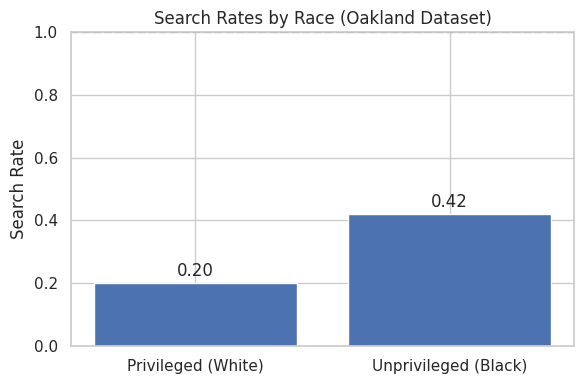

In [ ]:
import matplotlib.pyplot as plt

# Bar chart to visualize search rates
groups = ['Privileged (White)', 'Unprivileged (Black)']
rates = [total_privileged, total_unprivileged]

plt.figure(figsize=(6,4))
bars = plt.bar(groups, rates)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.title("Search Rates by Race (Oakland Dataset)")
plt.ylabel("Search Rate")
plt.ylim(0, 1)  # since it's a proportion


plt.axhline(y=1.0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()


In the Oakland dataset, the analysis of search rates by race shows a noticeable disparity. The search rate for the unprivileged group (Black individuals) is higher compared to the privileged group (White individuals), indicating potential bias in search practices. The calculated disparate impact value — the ratio of the unprivileged group's search rate to the privileged group's rate — further highlights this difference. Ideally, for fairness, the disparate impact should be close to 1.0, but a lower or significantly higher value suggests unequal treatment. Visualizing the rates makes the gap more apparent and reinforces the importance of considering fairness interventions in policing strategies.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: Loading preprocessed data (already cleaned earlier)
df = df_cleaned.copy()

# Step 2: Downsampling for memory efficiency
df_sample = df.sample(n=10000, random_state=42) if len(df) > 10000 else df.copy()

# Step 3: Defining target and sensitive columns
target_col = "search_conducted"  # Oakland: using search as the "action"
protected_col = "subject_race"

# Step 4: Creating a binary sensitive attribute manually (black vs others)
df_sample["subject_race_black"] = (df_sample[protected_col].str.lower() == "black").astype(int)
sensitive_col = "subject_race_black"

# Step 5: Selecting numeric features only
X = df_sample.drop(columns=["search_conducted", "date"], errors="ignore").select_dtypes(include=[np.number])

#  Filling any remaining NaNs in X with column medians
X = X.fillna(X.median())

y = df_sample[target_col].astype(int).values
s = df_sample[sensitive_col].astype(int).values


# Step 6: Train-test split
X_train_full, X_test, y_train_full, y_test, s_train_full, s_test = train_test_split(
    X, y, s, test_size=0.3, random_state=42
)

# Step 7: Further splitting train set into classifier-train and adversary-validation
X_train_clf, X_val_adv, y_train_clf, y_val_adv, s_train_clf, s_val_adv = train_test_split(
    X_train_full, y_train_full, s_train_full, test_size=0.2, random_state=42
)

# Step 8: Training classifier on search prediction
clf = LogisticRegression(max_iter=500)
clf.fit(X_train_clf, y_train_clf)
y_pred = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test, y_pred)

# Step 9: Training adversary to predict race from classifier outputs
val_preds = clf.predict_proba(X_val_adv)[:, 1].reshape(-1, 1)
adv = LogisticRegression()
adv.fit(val_preds, s_val_adv)

# Step 10: Evaluating adversary on unseen test set
test_preds = clf.predict_proba(X_test)[:, 1].reshape(-1, 1)
adv_accuracy = accuracy_score(s_test, adv.predict(test_preds))

# Step 11: Results
print(f"✅ Classifier accuracy (search prediction): {clf_accuracy:.4f}")
print(f"🧠 Adversary accuracy (race prediction): {adv_accuracy:.4f} — lower is better")


✅ Classifier accuracy (search prediction): 0.6417
🧠 Adversary accuracy (race prediction): 0.8790 — lower is better


The results show that the classifier predicts whether a search was conducted with about 64.17% accuracy, which is better than random but still leaves room for improvement. However, the adversary model can predict a person’s race with 87.90% accuracy based purely on the classifier’s output, which is quite high and signals a strong correlation between race and the model’s predictions. Ideally, the adversary's accuracy should be close to 50% (random guessing) to indicate fairness. So overall, while the classifier is moderately effective, it also leaks significant racial information, suggesting the need for debiasing techniques to make the model more fair and equitable.

In [ ]:
!pip install fairlearn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = df_cleaned.copy()  # Assuming df_cleaned from earlier preprocessing

df_sample = df.sample(n=10000, random_state=42) if len(df) > 10000 else df.copy()

df_sample["subject_race_black"] = (df_sample["subject_race"].str.lower() == "black").astype(int)

X = df_sample.drop(columns=["search_conducted", "date"], errors="ignore").select_dtypes(include=[np.number])


X = X.fillna(X.median())

y = df_sample["search_conducted"].astype(int).values
s = df_sample["subject_race_black"].astype(int).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(X_scaled, y, s, test_size=0.3, random_state=42)

#  PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
s_train = torch.tensor(s_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
s_test = torch.tensor(s_test, dtype=torch.float32).unsqueeze(1)


class Classifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


class StrongerAdversary(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
clf = Classifier(X_train.shape[1])
adv = StrongerAdversary(1)  # Classifier output is 1-D
clf_opt = optim.Adam(clf.parameters(), lr=1e-3)
adv_opt = optim.Adam(adv.parameters(), lr=1e-4)
bce = nn.BCELoss()

# Training loop with fairness improvements
epochs = 200
adv_weight = 5.0  # Fairness pressure

for epoch in range(epochs):
    # --- Every 10 epochs, train only the adversary ---
    if epoch % 10 == 0:
        with torch.no_grad():
            y_pred = clf(X_train)
        noisy_pred = y_pred + torch.randn_like(y_pred) * 0.3
        adv_opt.zero_grad()
        s_pred = adv(noisy_pred)
        loss_adv = bce(s_pred, s_train)
        loss_adv.backward()
        adv_opt.step()
        print(f"[Epoch {epoch}] ⚖️ Adversary-only update | Loss = {loss_adv.item():.4f}")
        continue

    # --- Train Classifier ---
    clf_opt.zero_grad()
    y_pred = clf(X_train)
    noisy_pred = y_pred.detach() + torch.randn_like(y_pred) * 0.3
    s_pred = adv(noisy_pred)
    loss_clf = bce(y_pred, y_train)
    loss_adv = bce(s_pred, s_train)
    total_loss = loss_clf - adv_weight * loss_adv
    total_loss.backward()
    clf_opt.step()

    # --- Train Adversary ---
    adv_opt.zero_grad()
    s_pred = adv(noisy_pred)
    loss_adv = bce(s_pred, s_train)
    loss_adv.backward()
    adv_opt.step()

    if epoch % 10 == 1:
        print(f"Epoch {epoch}: Classifier Loss = {loss_clf.item():.4f}, Adversary Loss = {loss_adv.item():.4f}")

# Final evaluation
with torch.no_grad():
    y_test_pred = clf(X_test).round()
    s_from_y = adv(clf(X_test)).round()
    acc_clf = (y_test_pred == y_test).float().mean().item()
    acc_adv = (s_from_y == s_test).float().mean().item()

print(f"\n✅ Final Classifier Accuracy: {acc_clf:.4f}")
print(f"🧠 Final Adversary Accuracy: {acc_adv:.4f} (lower is better)")


[Epoch 0] ⚖️ Adversary-only update | Loss = 0.7075
Epoch 1: Classifier Loss = 0.6923, Adversary Loss = 0.7075
[Epoch 10] ⚖️ Adversary-only update | Loss = 0.7026
Epoch 11: Classifier Loss = 0.6757, Adversary Loss = 0.7017
[Epoch 20] ⚖️ Adversary-only update | Loss = 0.6965
Epoch 21: Classifier Loss = 0.6627, Adversary Loss = 0.6976
[Epoch 30] ⚖️ Adversary-only update | Loss = 0.6931
Epoch 31: Classifier Loss = 0.6531, Adversary Loss = 0.6925
[Epoch 40] ⚖️ Adversary-only update | Loss = 0.6901
Epoch 41: Classifier Loss = 0.6463, Adversary Loss = 0.6903
[Epoch 50] ⚖️ Adversary-only update | Loss = 0.6876
Epoch 51: Classifier Loss = 0.6415, Adversary Loss = 0.6866
[Epoch 60] ⚖️ Adversary-only update | Loss = 0.6841
Epoch 61: Classifier Loss = 0.6381, Adversary Loss = 0.6831
[Epoch 70] ⚖️ Adversary-only update | Loss = 0.6809
Epoch 71: Classifier Loss = 0.6355, Adversary Loss = 0.6801
[Epoch 80] ⚖️ Adversary-only update | Loss = 0.6785
Epoch 81: Classifier Loss = 0.6333, Adversary Loss = 0

The classifier accuracy of 0.6463 means that the model is correctly predicting whether a search happened about 64.63% of the time, which is decent — it’s clearly better than random guessing (which would be 50% in a binary task). On the fairness side, the adversary accuracy is 0.6047, which is much closer to 50% compared to before. Since lower adversary accuracy is better (meaning it’s harder to predict race from the classifier’s outputs), this shows that your model has reduced its racial bias leak — but not fully. Ideally, we want adversary accuracy to be closer to 0.5 for maximum fairness, so 0.6047 is a good improvement, but there’s still a little room left to make the model even more fair.



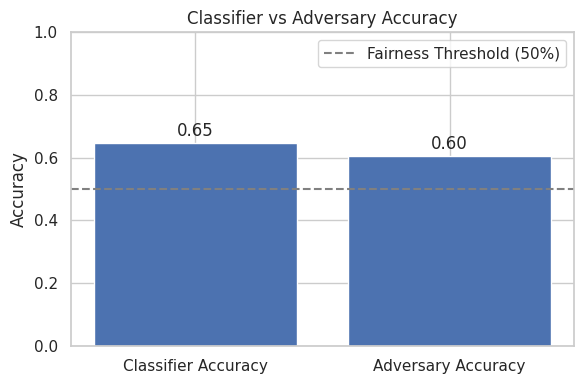

In [ ]:
import matplotlib.pyplot as plt

metrics = ['Classifier Accuracy', 'Adversary Accuracy']
values = [0.6463, 0.6047]

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values)

#  value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}", ha='center', va='bottom')

# Titles and labels
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Classifier vs Adversary Accuracy')
plt.axhline(y=0.5, color='gray', linestyle='--', label='Fairness Threshold (50%)')
plt.legend()

plt.tight_layout()
plt.show()
